Steane code
==========

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474

2. Perform a logical Hadamard

3. Peform a logical CX to entangle the two logical qubits 

4. Set up ancilla based on the parity matrix

5. Reverse the set up

**Please note that this code is not complete and has not been fully tested.  
There may be some undetected errors.  Please use at your own risk.**

Import the necessary function modules, including the SteaneCodeLogicalQubit class.  The methods of this class are called in this notebook.

In [1]:
from qiskit import(
  QuantumCircuit,
  QuantumRegister,
  ClassicalRegister,
  execute,
  Aer)

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

from circuits import SteaneCodeLogicalQubit

Define constants so the process flow can be controlled from one place:

In [2]:
SECOND_LOGICAL = False             #Set up second logical qubit?  NB, error correction is not possible with two logical qubits

FIRST_LOGICAL_X = False           #Apply logical X operation? 
SECOND_LOGICAL_X = False          #Apply logical X operation? 

FIRST_LOGICAL_H = False            #Hadamard on first logical qbit
SECOND_LOGICAL_H = False          #Hadamard on second logical qbit

FIRST_DECODE = True               #Reverse the first logical qubit
SECOND_DECODE = False            #Reverse the second logical qubit

LOGICAL_CX = False                #Logical CX
CX_CONTROL = 0                    #Logical control bit
CX_TARGET = 1                     #Logical target bit

ANCILLAS = True                   #Ancillas are active?
CORRECT_ERROR = True              #Correct errors (NB, can only do this with one logical QUBIT)
TESTING = True                    #Test by applying and X or Z error to one of the qubits
TEST_X_QUBIT = 5                  #Qbit to set bit flip- Starts at zero.
TEST_X_LOGICAL = 0                #logical Qbit to set bit flip- Starts at zero.
TEST_Z_QUBIT = 0                  #Qbit to phase flip- Starts at zero.
TEST_Z_LOGICAL = 0                #logical Qbit to set phase flip- Starts at zero.

NOISE = False                     #Test with noise
SHOTS = 1000                      #Number of shots to run    
MEASURE_NOISE = 0.0000001         #Measurement noise
GATE_NOISE = 0.0003               #Gate noise

SIMULATOR = Aer.get_backend('qasm_simulator')

Define noise model

We specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = [[0,0,0,1,1,1,1],
                       [0,1,1,0,0,1,1],
                       [1,0,1,0,1,0,1]]

Create an instance of the logical qubits needed.  The parity check matrix above as an input.

The number of qubits needed is an argument to the class and should be 1 or 2 at present.

In [4]:
if SECOND_LOGICAL:
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix,CORRECT_ERROR)
else:
    qubit = SteaneCodeLogicalQubit(1, parity_check_matrix,CORRECT_ERROR)

Use a method to initialise the logical qubits as a logical zero as required.

In [5]:
qubit.set_up_logical_zero(0)
if SECOND_LOGICAL:
    qubit.set_up_logical_zero(1)
qubit.barrier()

If TESTING is active we test the ancilla with an X and Z error and check that the correct error syndrome is returned.

In [6]:
if TESTING:
    qubit.force_X_error(TEST_X_QUBIT,TEST_X_LOGICAL)   #force X error for testing
    qubit.force_Z_error(TEST_Z_QUBIT,TEST_Z_LOGICAL)   #force Z error for testing
    qubit.barrier()

Set up ancilla and make a logical measurement

In [7]:
if ANCILLAS:
    qubit.set_up_ancilla(0)
    if SECOND_LOGICAL:
        qubit.set_up_ancilla(1)
    qubit.barrier()

Correct errors found in ancilla.  NB at present errors can only be corrected if one qubit is simulated due to memory constaints.

In [8]:
if CORRECT_ERROR:
    qubit.correct_errors(0)

Apply logical X gate

In [9]:
if FIRST_LOGICAL_X:
    qubit.logical_gate_X(0)
    qubit.barrier()
if SECOND_LOGICAL_X:
    qubit.logical_gate_X(1)
    qubit.barrier()

Apply logical Hadamard

In [10]:
if FIRST_LOGICAL_H:
    qubit.logical_gate_H(0)
    qubit.barrier()
if SECOND_LOGICAL_H:
    qubit.logical_gate_H(1)
    qubit.barrier()

Apply logical CX

In [11]:
if LOGICAL_CX:
    qubit.logical_gate_CX(CX_CONTROL,CX_TARGET)
    qubit.barrier()

Uncompute initialisation of logical qubit

In [12]:
if FIRST_DECODE:
    qubit.decode(0)
    if SECOND_DECODE:
        qubit.decode(1)
    qubit.barrier()

Populate noise model

In [13]:
def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)
    error_gate3 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["h"])  # single qubit gate error is applied to h gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
    noise_model.add_all_qubit_quantum_error(error_gate3, ["cz"]) # same two qubit gate error is applied to cz gates

    return noise_model

In [14]:
if NOISE:
    noise_model = get_noise(MEASURE_NOISE,GATE_NOISE)

Measure qubits

In [15]:
qubit.logical_measure(0)
if SECOND_LOGICAL:
    qubit.logical_measure(1)
qubit.barrier()

In [16]:
#Measurement noise
if NOISE:
    result = execute(qubit, SIMULATOR, noise_model=noise_model, shots=SHOTS).result()
else:
    result = execute(qubit, SIMULATOR, shots=SHOTS).result()

Execute results and print out.  The format is three bits for the Z error address, three bits for the X error address and seven bits for the Steane data bit. 

In [26]:
counts = result.get_counts(qubit)
print ('The different states can be counted.  The simulated result are', counts)
for key in counts.keys():
    print(key[-7:])

The different states can be counted.  The simulated result are {'0000 110 001 0000000': 1000}
0000000


Print out circuit:

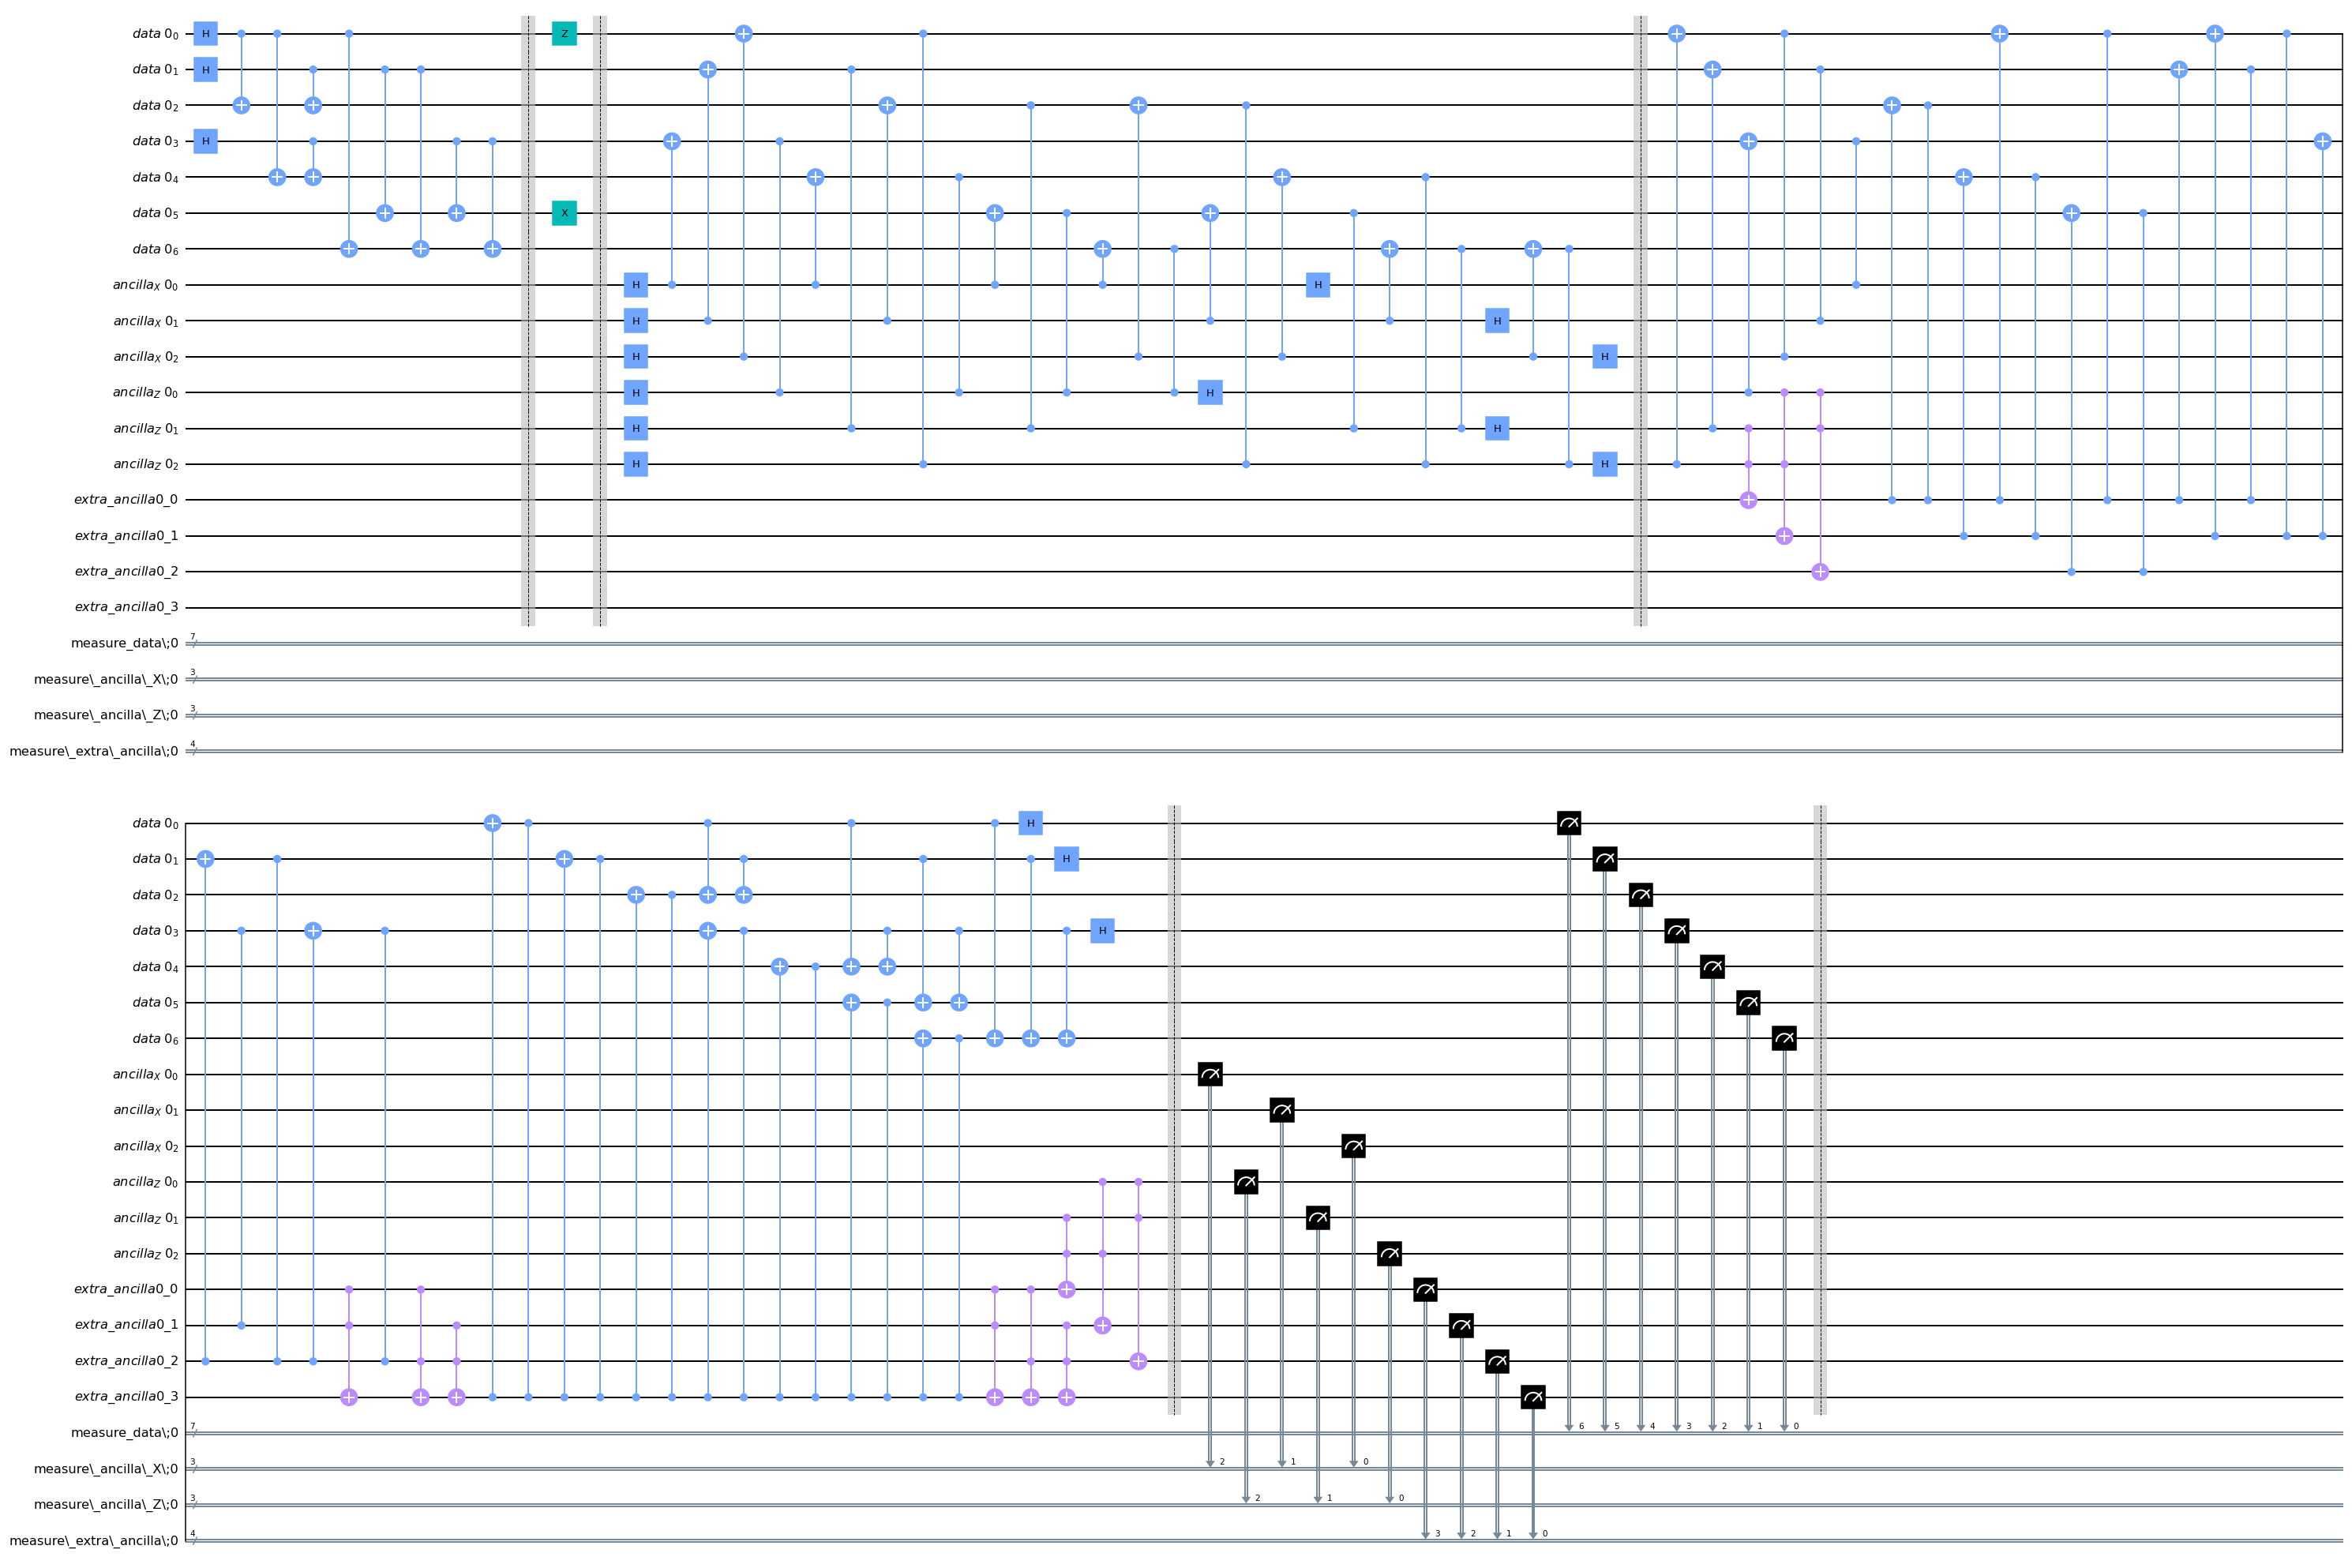

In [18]:
qubit.draw(output='mpl', filename = 'auto_qubit.jpg', fold=60)